<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Heuristic-Optimization" data-toc-modified-id="Heuristic-Optimization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Heuristic Optimization</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#A-Hard-Optimization-Problem" data-toc-modified-id="A-Hard-Optimization-Problem-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>A Hard Optimization Problem</a></span></li><li><span><a href="#Partical-Swarm-Optimization" data-toc-modified-id="Partical-Swarm-Optimization-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Partical Swarm Optimization</a></span><ul class="toc-item"><li><span><a href="#Implementation" data-toc-modified-id="Implementation-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Implementation</a></span></li><li><span><a href="#Test-Cases" data-toc-modified-id="Test-Cases-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Test Cases</a></span></li></ul></li><li><span><a href="#Genetic-Algorithm" data-toc-modified-id="Genetic-Algorithm-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Genetic Algorithm</a></span><ul class="toc-item"><li><span><a href="#Notes-on-genetic-algorithms" data-toc-modified-id="Notes-on-genetic-algorithms-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Notes on genetic algorithms</a></span></li><li><span><a href="#Implementation" data-toc-modified-id="Implementation-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Implementation</a></span></li><li><span><a href="#Test-Cases" data-toc-modified-id="Test-Cases-1.4.3"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>Test Cases</a></span></li></ul></li><li><span><a href="#Nelder-Mead-(Simplex)-Algorithm" data-toc-modified-id="Nelder-Mead-(Simplex)-Algorithm-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Nelder-Mead (Simplex) Algorithm</a></span></li></ul></li></ul></div>

In [2]:
# Preliminary imports - we'll be writing our own optimizers so we don't need scikit-learn
import matplotlib.pyplot as plt
import numpy as np

## Heuristic Optimization ##
### Introduction ###
All of the algorithms we have covered so far assume that you can calculate the gradient of the objective function with respect to their parameters. However, in many applications an analytical form of the gradient with respect to your model parameters is unavailable, or impractical to calculate. In addition, there are cases where gradient based optimizations are prone to getting stuck in local minima. We discussed several strategies for gradient based optimization to that are meant to circumvent getting stuck in relatively shallow minima, including learning rate annealing and momentum concepts, that when paired with proper hyperparameter selection can be relatively robust. Nevertheless, you can always find problems to break any algorithm.

These two challenges--namely, difficult/unavailable gradients and highly non-convex problems--have motivated extensive research into so-called heuristic optimization algorithms. Heuristic algorithms are motivated by intuition rather than a rigorous guarrantee about convergence. Nevertheless, some are extremely general and you will see them pop-up again and again in diverse contexts. In this lecture I am just going to give you a flavor of three heuristic algorithms as an entry point to this very diverse topic. All of them are gradient-free, meaning you don't need access to the derivative of your objective function, so they address our first motivation. Using three very different mechanisms, they all also address the problem of avoiding shallow minima. 

### A Hard Optimization Problem ###

Over the many "hard" problems have been posed that are designed to break various optimization algorithms. These are so popular, that as of writing this, there is even a [wikipedia page](https://en.wikipedia.org/wiki/Test_functions_for_optimization) dedicated to them. For this lecture we will just focus on the "Rastrigin" function:

$$ f(\mathbf{x}) = 10n + \sum_i^{n}\left[x_i^2 - 10\mathrm{cos}\left(2\pi x_i\right)\right] $$

where $n$ defines the dimensionality of the problem (i.e., the number of $x$ variables, where $\mathbf{x}$ is a vector) and 10 is a scale factor that could be changed. The global minimum for this function is at $\mathbf{x}=\mathbf{0}$, with many nearby local minima that gradually increase as you move away from the origin. Let's plot the function to see what we are dealing with:


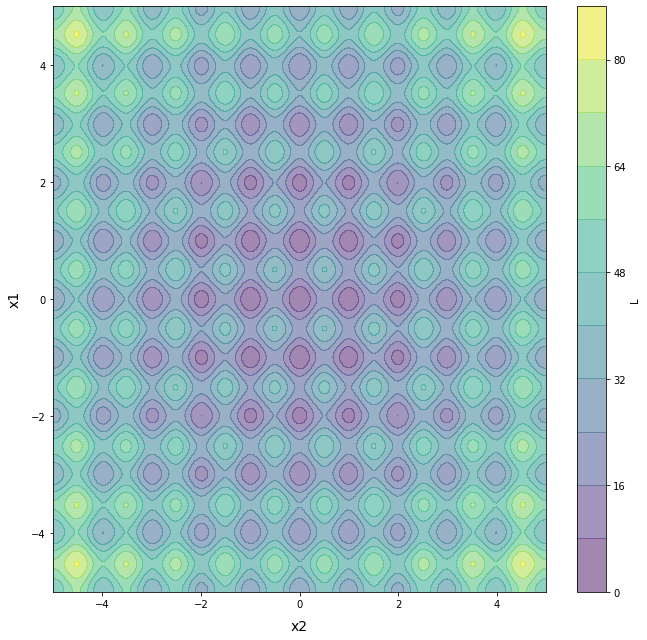

In [3]:
# Our "difficult" objective function
def rastrigin(x,n=2,A=10.0):    
    return A*n + np.sum(x**(2.0)-A*np.cos(2.0*np.pi*x))

# Define contour plot function                                                                                                                                                                                            
def surf_plot_2(x,y,f,lines=(),dims=(4.5,4),n=10,labels=None,c_opt=True,cmap='viridis',alpha=0.5,vecs=None):

  # Make x,y,z grid
  X, Y = np.meshgrid(x, y)
  Z = np.zeros(X.shape)
  for count_i,i in enumerate(x):
      for count_j,j in enumerate(y):
          Z[count_i,count_j] = f(np.array([i,j]))

  # Make contour plot
  fig = plt.figure(figsize=dims)
  if c_opt:
      contours = plt.contour(Y, X, Z.T, n, colors='black') # note reverse order for contour and imshow
      plt.clabel(contours, inline=True, fontsize=8) # contour labels
  plt.imshow(Z, extent=[min(y), max(y), min(x), max(x)], origin='lower',
              cmap=cmap, alpha=alpha) # note, x is treated as y and y as x in imshow
  cbar = plt.colorbar()

  # List of colors for line plots
  # Note: because of imshow behavior, x and y are reversed for plotting
  color_list = [(0.05,0.35,0.75),(0.05,0.8,0.6),(0.9,0.3,0.05),(0.05,0.05,0.05),(0.9,0.6,0.05),(0.9,0.5,0.7),(0.35,0.7,0.9),(0.95,0.9,0.25)]*100 
  for count_i,i in enumerate(lines):
    if labels:
      plt.plot(i[:,1],i[:,0],linestyle='-',linewidth=1.0,marker='.',markersize=10.0,color=color_list[count_i],label=labels[count_i])
    else:
      plt.plot(i[:,1],i[:,0],linestyle='-',linewidth=1.0,marker='.',markersize=10.0,color=color_list[count_i])
      if vecs:
        print(vecs[count_i])
        plt.quiver(i[:,1],i[:,0],vecs[count_i][:,1]*100,vecs[count_i][:,0])#,norm="Normalize")


  # Set labels and clean up layout
  plt.xlim(min(y),max(y))
  plt.ylim(min(x),max(x))
  plt.ylabel("x1",fontsize=14,labelpad=10)
  plt.xlabel("x2",fontsize=14,labelpad=10)
  if labels: plt.legend()
  cbar.ax.set_ylabel('L')
  plt.tight_layout()
  plt.show()


# Define contour plot function                                                                                                                                                                                            
def surf_plot(x,y,f,lines=(),dims=(4.5,4),n=10,labels=None,c_opt=True,cmap='viridis',alpha=0.5,vecs=None,linestyle='-',title=None):

  # Make x,y,z grid
  X, Y = np.meshgrid(x, y)
  Z = np.zeros(X.shape)
  for count_i,i in enumerate(x):
      for count_j,j in enumerate(y):
          Z[count_i,count_j] = f(np.array([i,j]))

  # Make contour plot
  fig = plt.figure(figsize=dims)
  if c_opt:
      contours = plt.contour(Y, X, Z.T, n, colors='black') # note reverse order for contour and imshow
      plt.clabel(contours, inline=True, fontsize=8) # contour labels
  plt.contourf(Y,X,Z.T,extent=[min(y), max(y), min(x), max(x)], origin='lower',
               cmap=cmap, levels=10, alpha=alpha)
  cbar = plt.colorbar()

  # List of colors for line plots
  # Note: because of contourf behavior, x and y are reversed for plotting
  color_list = [(0.05,0.35,0.75),(0.05,0.8,0.6),(0.9,0.3,0.05),(0.5,0.5,0.5),(0.9,0.6,0.05),(0.9,0.5,0.7),(0.35,0.7,0.9),(0.95,0.9,0.25)]*100 
  stop = len(lines)
  for count_i,i in enumerate(lines):
    if labels:
      plt.plot(i[:,1],i[:,0],linestyle=linestyle,linewidth=1.0,marker='.',markersize=10.0,color=color_list[count_i],label=labels[count_i])
    else:
      plt.plot(i[:,1],i[:,0],linestyle=linestyle,linewidth=1.0,marker='.',markersize=10.0,color=color_list[count_i])
      if vecs:
        norm = (vecs[count_i][1:,0]**(2.0) + vecs[count_i][1:,1]**(2.0))**(0.5)
        plt.quiver(i[:-1,1],i[:-1,0],vecs[count_i][1:,1]/norm,vecs[count_i][1:,0]/norm)


  # Set labels and clean up layout
  plt.xlim(min(y),max(y))
  plt.ylim(min(x),max(x))
  plt.ylabel("x1",fontsize=14,labelpad=10)
  plt.xlabel("x2",fontsize=14,labelpad=10)
  if labels: plt.legend()
  if title: plt.title(title)
  cbar.ax.set_ylabel('L')
  plt.tight_layout()
  plt.show()



# Make a plot of our tough problem
surf_plot(np.linspace(-5,5,200),np.linspace(-5,5,200),rastrigin,dims=(9.5,9),c_opt=None)

**Note:** this function has a gradient that we could use to perform an optimization. Thus, we don't have to use a "gradient-free" method for this problem, but nevertheless we can. I encourage you to experiment with the gradient based optimizations to compare with the heuristic methods that I will illustrate here. On the other hand, this problem clearly presents a lot of local minima, so it will be good to illustrate how the different methods deal with avoiding traps and approximating the global maximum.   

### Partical Swarm Optimization ###
The first algorithm we will illustrate is based on the concepts of momentum, random walks, and communication. The idea is to use a lot of "walkers", or "particles", to sample the optimization surface, where each walker will move in a manner that explores space while also being pushed in the direction of the best spot discovered so far by itself or another walker. The updates for each particle, i, are:

$$\mathbf{x}_\mathrm{i}^\mathrm{t+1} = \mathbf{x}_\mathrm{i}^\mathrm{t} + \alpha \mathbf{v}_\mathrm{i}^\mathrm{t+1}$$
$$\mathbf{v}_\mathrm{i}^\mathrm{t+1} = \eta \mathbf{v}_\mathrm{i}^\mathrm{t} + \phi_\mathrm{1} \mathbf{r}_\mathrm{1}\left(\mathbf{x}_\mathrm{i,best} - \mathbf{x}_\mathrm{i}^\mathrm{t}\right) + \phi_\mathrm{2} \mathbf{r}_\mathrm{2}\left(\mathbf{x}_\mathrm{all,best} - \mathbf{x}_\mathrm{i}^\mathrm{t}\right) $$

Here $\mathbf{x}$ refers to each particle's position in the n-dimensional parameter space and $\mathbf{v}$ refers to each particle's velocity. The first equation is easy to interpret: the position of each particle at the next step is based on its velocity. The parameter $\alpha$ is the equivalent of a learning rate, and sometimes it is omitted since the parameters in the second equation play a similar role with more fine-grained control. The terms in the second equation are marginally more complicated but still easy to interpret. The first term corresponds to the velocity in the previous step. Thus, this term plays a similar role to momentum, and the hyperparameter $\eta \in [0,1]$ is used to weight its relative contribution to the velocity update. The second term is based on the vector separating the current position ($\mathbf{x}_\mathrm{i}^{t}$) of the particle from the best solution that has been visited by that particle so far during the optimization ($\mathbf{x}_\mathrm{i,best}$). In other words, this term tends to pull the particle back towards its best personal solution so far. The contribution of this term to the velocity update is controlled by the hyperparameter $\phi_\mathrm{1} \in [0,1]$. The third term is based on the vector separating the current position ($\mathbf{x}_\mathrm{i}^{t}$) of the particle from the best solution that has been visited by <i>any</i> particle so far during the optimization ($\mathbf{x}_\mathrm{all,best}$). In other words, this term tends to pull the particle towards the best  solution found so far. The contribution of this term to the velocity update is controlled by the hyperparameter $\phi_\mathrm{2} \in [0,1]$. Lastly, there are $\mathbf{r}_\mathrm{1}$ and $\mathbf{r}_\mathrm{2}$ factors in these expressions. These are n-dimensional vectors of random numbers sampled from $[0,1]$ that add a stochastic element to each update. In other words, instead of determistically moving towards a linear combination of the personal and global best, these factors randomly scale the update a little, so that it is still biased towards these directions but also has a random exploration element. Usually, $\mathbf{r}_\mathrm{1}$ and $\mathbf{r}_\mathrm{2}$ are resampled for each particle at each iteration. 

Let's note a few things. First, there is no gradient call in the expressions for PSO. Instead, there is a reference to the "best" solution for each particle and the "best" solution over all particles. This means that we only need to be able to evaluate our loss function (L) at each step, but we don't need to the gradient. Second, you can kind of think about the PSO heuristic as weakly estimating the gradient by the information exchange between particles through the $\mathbf{x}_\mathrm{all,best}$ term, as it informs each particle of a direction that is eventually downhill if they were to keep pursuing it. Third, there is clearly a strong stochastic element here that promotes exploration. Through the twin elements of the random walk and using a swarm of particles, PSO is very good at escaping local minima. Depending on the dimensionality of the problem, we might need more particles to adequately sample the optimization landscape. For this reason, PSO tends to only be used for relatively low dimensional problems.  

#### Implementation ####
Similar to gradient descent, we will still need to initialize the PSO particle positions and velocities. This serves the same role as an initial guess. We will typically initialize the positions by randomly sampling parameter space using some user-specified min/max values. Similarly, the velocities will be initialized based on the min/max range of each parameter. 

In [4]:
from copy import deepcopy

# Our "difficult" objective function
# NOTE: we are vectorizing the function so that it can accept a 2D array of values.
def rastrigin_pso(x,n=2,A=10.0):    
    return A*n + np.sum(x**(2.0)-A*np.cos(2.0*np.pi*x),axis=1)

# Simple PSO implementation
def pso(L,n=20,nx=2,xmin=None,xmax=None,omega=0.2,p1=0.5,p2=0.5,tmax=1000):

    # Fix the seed for reproducibility
    np.random.seed(10104041)

    # Make sure the user has supplied initialization information
    if xmin is None or xmax is None:
        print("ERROR: min/max for each variable must be supplied as arrays.")
        return
    
    # x initializations
    x = np.zeros([n,nx,tmax+1]) 
    x[:,:,0] = (np.random.random(size=(n,nx))-0.5) * np.array(xmax-xmin) + np.array((xmax+xmin)/2.0)
    x_best = deepcopy(x[:,:,0]) # we use deepcopy because x_best needs to be indpendent of this slice

    # v initializations
    v = np.zeros([n,nx,tmax+1])
    v[:,:,0] = ((np.random.random(size=(n,nx))-0.5)*2) * np.array(xmax-xmin) * 0.1

    # individual and global best initializations
    L_best = L(x[:,:,0])
    L_g_best = L_best[np.argmin(L_best)]
    x_g_best = x_best[np.argmin(L_best),:]

    # run tmax steps
    for t in range(0,tmax):
        
        # Update velocities
        v[:,:,t+1] = omega*v[:,:,t] +\
                     np.random.random(size=(n,nx))*p1*(x_best - x[:,:,t]) +\
                     np.random.random(size=(n,nx))*p2*(x_g_best - x[:,:,t])

        # Update positions
        x[:,:,t+1] = x[:,:,t] + v[:,:,t+1]

        # Update best lists
        L_here = L(x[:,:,t+1])
        inds = np.where((L_here - L_best) < 0)
        x_best[inds] = x[:,:,t+1][inds]
        L_best[inds] = L_here[inds]
        
        # Update global
        if min(L_best) < L_g_best:
            x_g_best = x_best[np.argmin(L_best),:]
            L_g_best = min(L_best)

    return x,v,x_g_best,L_g_best

A couple notes are in order. First, the initialization of the particle positions and velocity takes up half of the lines in our function, whereas the main loop is relatively short. This often happens in programming problems, where the main theoretical thing you are trying to implement is actually short but the supporting code is relatively long. Second, we have vectorized the loss function and particle updates. What I mean by this is that we perform these operations on the whole array of particles rather than putting them inside a loop where each one gets updated individually. This idea of substituting a linear algebra expression for a `for` loop is very common and is usually the first thing you should think about when trying to speed up your code. 

#### Test Cases ####
In the next few cells, let's run PSO with some exploratory sets of parameters to evaluate its performance in minimizing the Rastrigin function. 

Best params (loss): [-1.62728398e-09  7.39481796e-09] (1.0658141036401503e-14)


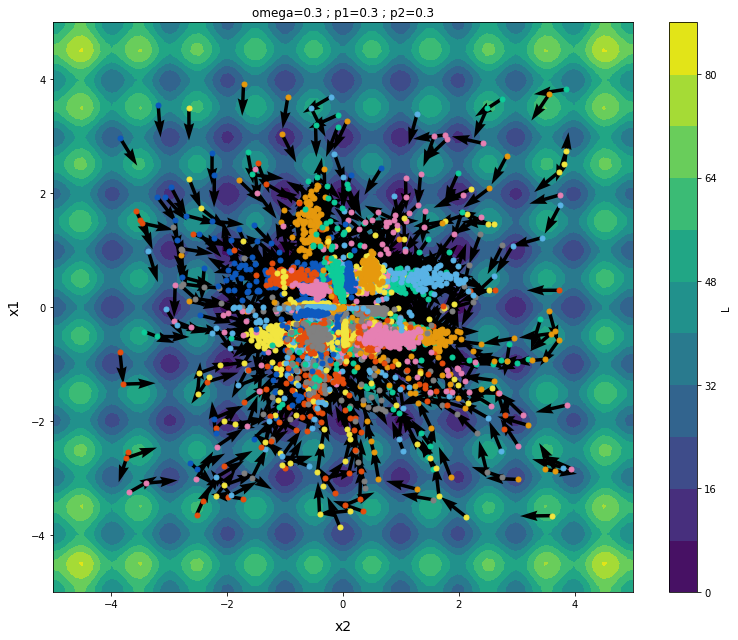

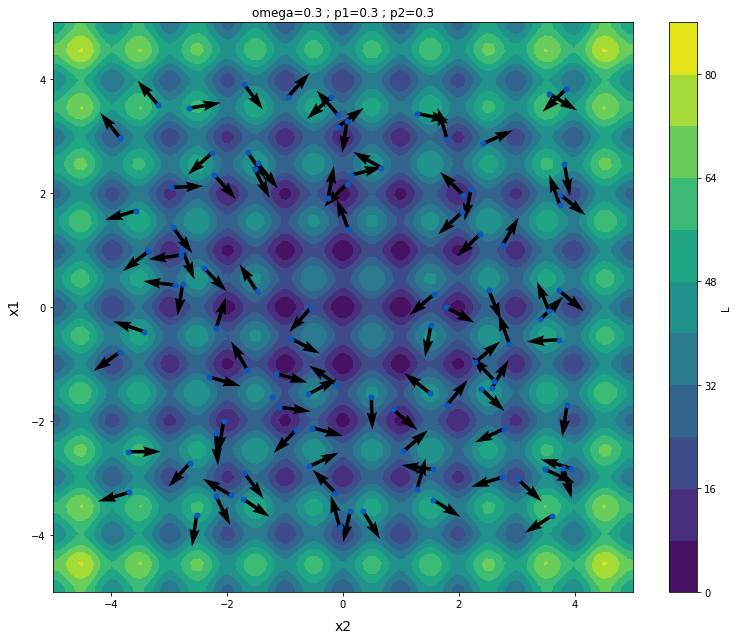

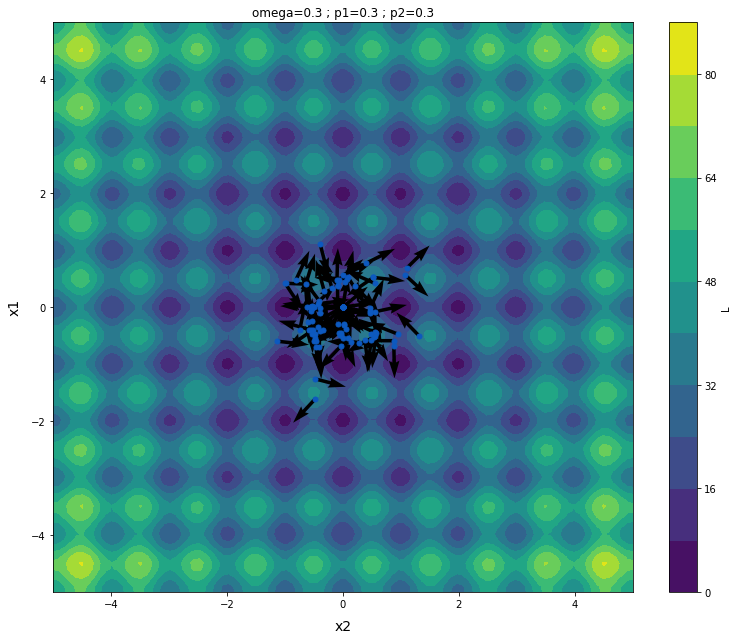

Best params (loss): [2.48217771e-07 8.77487029e-07] (1.6498091781613766e-10)


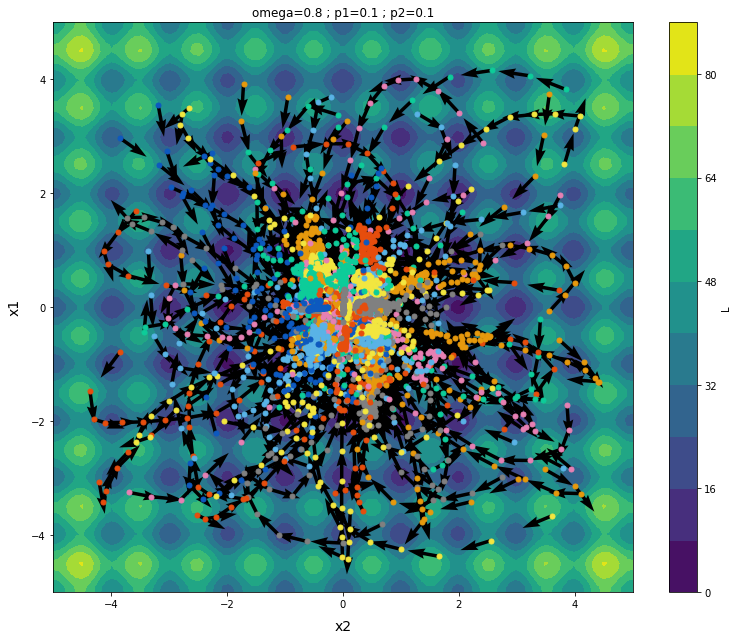

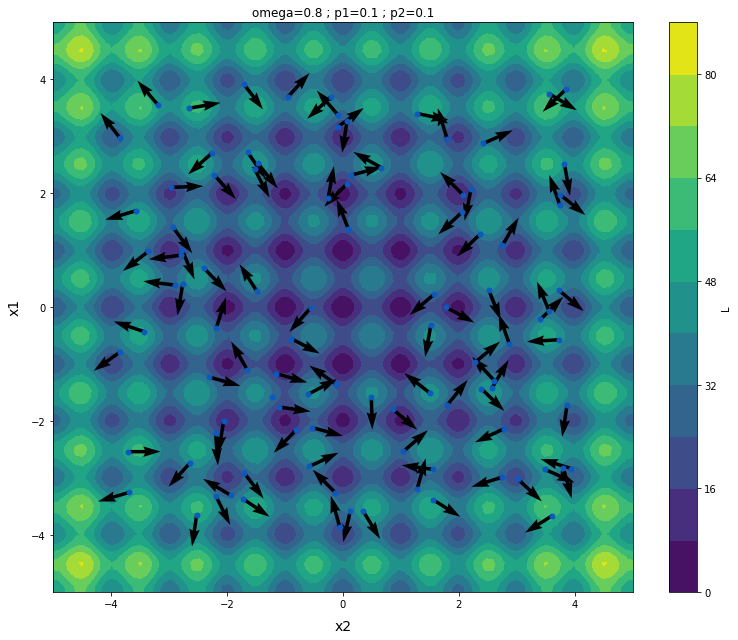

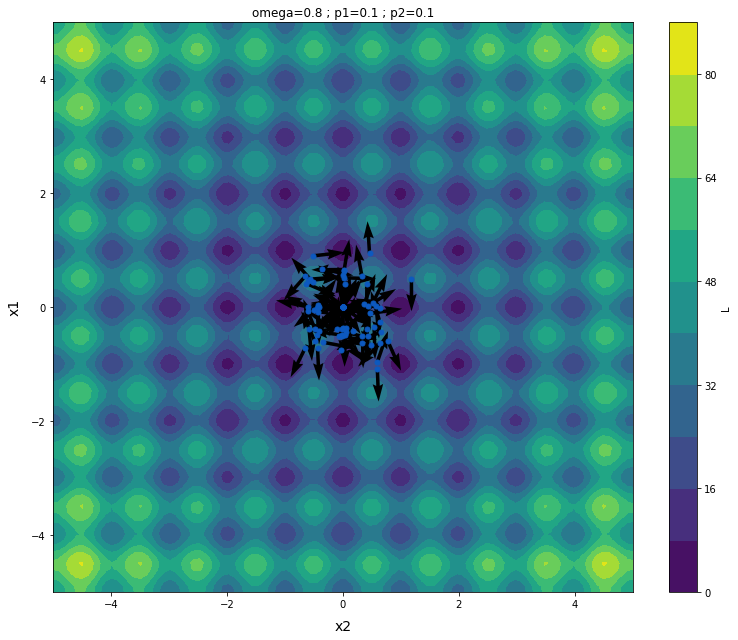

Best params (loss): [ 0.98285098 -0.0047923 ] (1.0285466983722422)


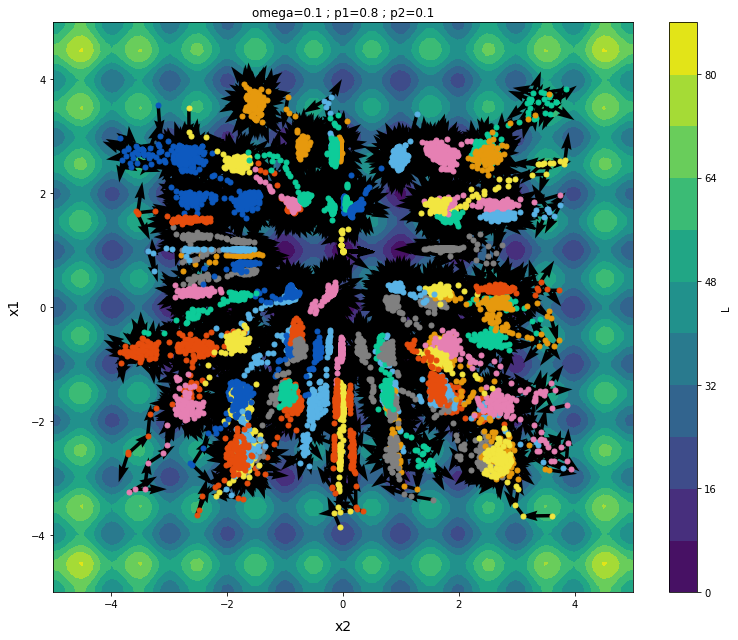

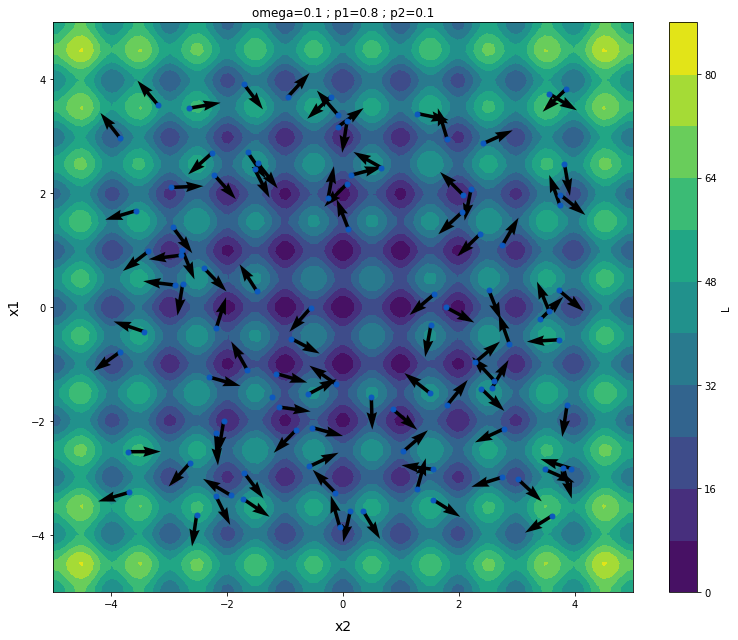

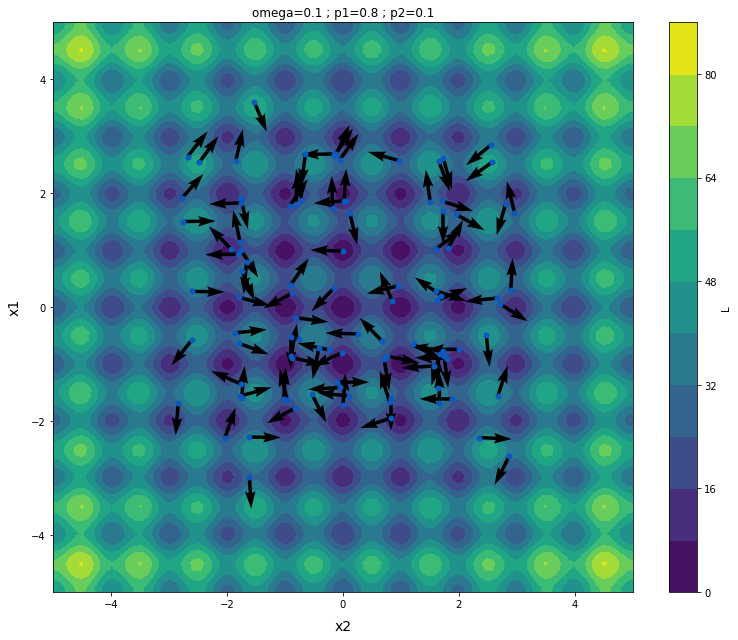

Best params (loss): [-9.94958638e-01 -9.37697797e-11] (0.9949590570932898)


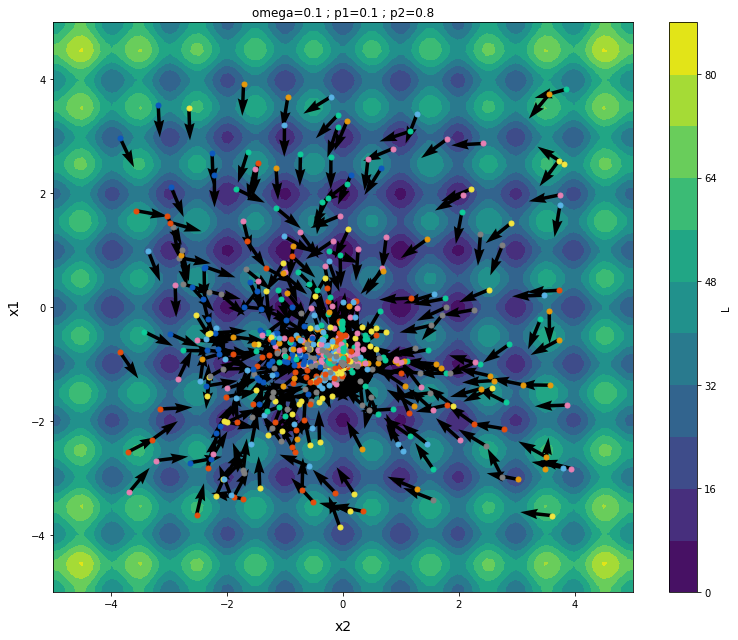

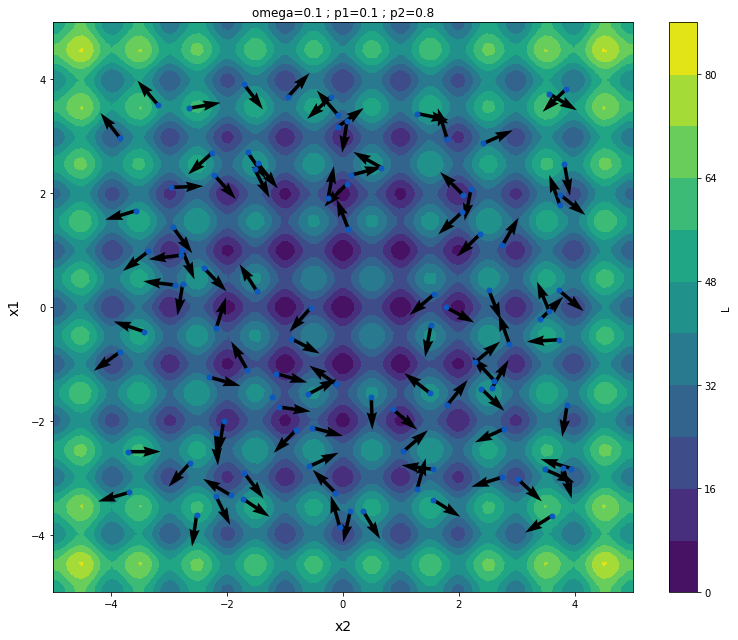

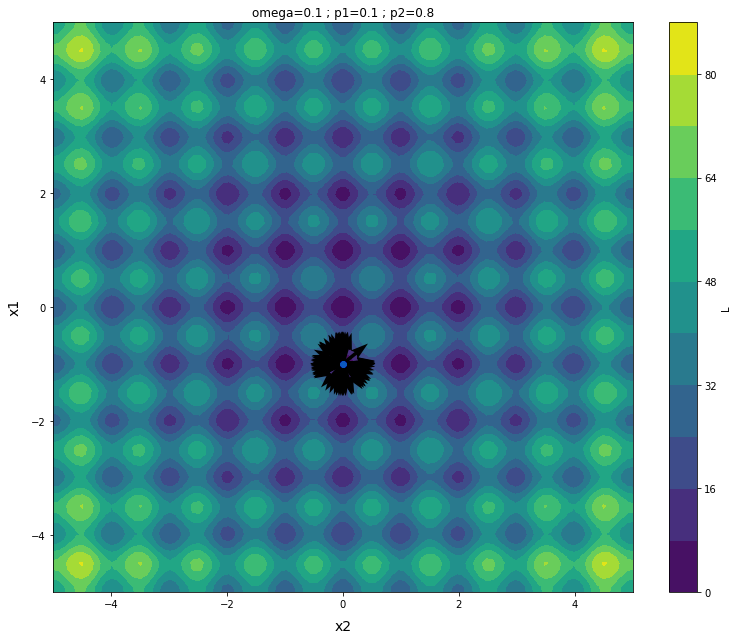

In [5]:
# Relatively optimized
x,v,x_g_best,L_g_best = pso(rastrigin_pso,n=100,xmin=np.array([-4,-4]),\
                            xmax=np.array([4,4]),tmax=100,omega=0.3,p1=0.3,p2=0.3)
print("Best params (loss): {} ({})".format(x_g_best,L_g_best))

# Plot trajectory (opt)
lines = [ x[_,:,:].T for _ in range(len(x)) ]
vecs = [ v[_,:,:].T for _ in range(len(v)) ]
surf_plot(np.linspace(-5,5,100),np.linspace(-5,5,100),rastrigin,\
          dims=(11,9),lines=lines,c_opt=False,alpha=1.0,vecs=vecs,\
          linestyle="None",title="omega=0.3 ; p1=0.3 ; p2=0.3")

# Plot initial (opt)
lines = [ x[:,:,0] ]
vecs = [ v[:,:,0] ]
surf_plot(np.linspace(-5,5,100),np.linspace(-5,5,100),rastrigin,\
          dims=(11,9),lines=lines,c_opt=False,alpha=1.0,vecs=vecs,\
          linestyle="None",title="omega=0.3 ; p1=0.3 ; p2=0.3")

# Plot final (opt)
lines = [ x[:,:,-1] ]
vecs = [ v[:,:,-1] ]
surf_plot(np.linspace(-5,5,100),np.linspace(-5,5,100),rastrigin,\
          dims=(11,9),lines=lines,c_opt=False,alpha=1.0,vecs=vecs,\
          linestyle="None",title="omega=0.3 ; p1=0.3 ; p2=0.3")

##############
# Momentum Dominated
##############
x,v,x_g_best,L_g_best = pso(rastrigin_pso,n=100,xmin=np.array([-4,-4]),\
                            xmax=np.array([4,4]),tmax=100,omega=0.8,p1=0.1,p2=0.1)
print("Best params (loss): {} ({})".format(x_g_best,L_g_best))

# Plot trajectory (momentum dominated)
lines = [ x[_,:,:].T for _ in range(len(x)) ]
vecs = [ v[_,:,:].T for _ in range(len(v)) ]
surf_plot(np.linspace(-5,5,100),np.linspace(-5,5,100),rastrigin,\
          dims=(11,9),lines=lines,c_opt=False,alpha=1.0,vecs=vecs,\
          linestyle="None",title="omega=0.8 ; p1=0.1 ; p2=0.1")

# Plot initial (momentum dominated)
lines = [ x[:,:,0] ]
vecs = [ v[:,:,0] ]
surf_plot(np.linspace(-5,5,100),np.linspace(-5,5,100),rastrigin,\
          dims=(11,9),lines=lines,c_opt=False,alpha=1.0,vecs=vecs,\
          linestyle="None",title="omega=0.8 ; p1=0.1 ; p2=0.1")

# Plot final (momentum dominated)
lines = [ x[:,:,-1] ]
vecs = [ v[:,:,-1] ]
surf_plot(np.linspace(-5,5,100),np.linspace(-5,5,100),rastrigin,\
          dims=(11,9),lines=lines,c_opt=False,alpha=1.0,vecs=vecs,\
          linestyle="None",title="omega=0.8 ; p1=0.1 ; p2=0.1")

##############
# P1 dominated
##############
x,v,x_g_best,L_g_best = pso(rastrigin_pso,n=100,xmin=np.array([-4,-4]),\
                            xmax=np.array([4,4]),tmax=100,omega=0.1,p1=0.8,p2=0.1)
print("Best params (loss): {} ({})".format(x_g_best,L_g_best))
lines = [ x[_,:,:].T for _ in range(len(x)) ]
vecs = [ v[_,:,:].T for _ in range(len(v)) ]

# Plot trajectory (p1 dominated)
surf_plot(np.linspace(-5,5,100),np.linspace(-5,5,100),rastrigin,\
          dims=(11,9),lines=lines,c_opt=False,alpha=1.0,vecs=vecs,\
          linestyle="None",title="omega=0.1 ; p1=0.8 ; p2=0.1")

# Plot initial (p1 dominated)
lines = [ x[:,:,0] ]
vecs = [ v[:,:,0] ]
surf_plot(np.linspace(-5,5,100),np.linspace(-5,5,100),rastrigin,\
          dims=(11,9),lines=lines,c_opt=False,alpha=1.0,vecs=vecs,\
          linestyle="None",title="omega=0.1 ; p1=0.8 ; p2=0.1")

# Plot final (p1 dominated)
lines = [ x[:,:,-1] ]
vecs = [ v[:,:,-1] ]
surf_plot(np.linspace(-5,5,100),np.linspace(-5,5,100),rastrigin,\
          dims=(11,9),lines=lines,c_opt=False,alpha=1.0,vecs=vecs,\
          linestyle="None",title="omega=0.1 ; p1=0.8 ; p2=0.1")

##############
# P2 dominated
##############
x,v,x_g_best,L_g_best = pso(rastrigin_pso,n=100,xmin=np.array([-4,-4]),\
                            xmax=np.array([4,4]),tmax=100,omega=0.1,p1=0.1,p2=0.8)
print("Best params (loss): {} ({})".format(x_g_best,L_g_best))
lines = [ x[_,:,:].T for _ in range(len(x)) ]
vecs = [ v[_,:,:].T for _ in range(len(v)) ]

# Plot trajectory (p2 dominated)
surf_plot(np.linspace(-5,5,100),np.linspace(-5,5,100),rastrigin,\
          dims=(11,9),lines=lines,c_opt=False,alpha=1.0,vecs=vecs,\
          linestyle="None",title="omega=0.1 ; p1=0.1 ; p2=0.8")

# Plot initial (p2 dominated)
lines = [ x[:,:,0] ]
vecs = [ v[:,:,0] ]
surf_plot(np.linspace(-5,5,100),np.linspace(-5,5,100),rastrigin,\
          dims=(11,9),lines=lines,c_opt=False,alpha=1.0,vecs=vecs,\
          linestyle="None",title="omega=0.1 ; p1=0.1 ; p2=0.8")

# Plot final (p2 dominated)
lines = [ x[:,:,-1] ]
vecs = [ v[:,:,-1] ]
surf_plot(np.linspace(-5,5,100),np.linspace(-5,5,100),rastrigin,\
          dims=(11,9),lines=lines,c_opt=False,alpha=1.0,vecs=vecs,\
          linestyle="None",title="omega=0.1 ; p1=0.1 ; p2=0.8")



### Genetic Algorithm ###
Similar to PSO, genetic algorithms use a population of candidates to broadly explore the optimization landscape, however they use a very different mechanism for exploration. Whereas PSO used a physically inspired heuristic of particle trajectories to nagivate the landscape, genetic algorithms, per their namesake, use an evolutionary-inspired heuristic. At a high-level, what genetic algorithms do is maintain a pool of candidate solutions and at each step of the optimization perform "selection", "cross-over", and "mutation". The "selection" step is used to keep the most promising solutions in each generation with respect to objective function; the "cross-over" step serves to exchange information between the reatained solutions; and the "mutation" step is meant to introduce variety into the population of solutions. As you might expect, the details of these individual steps can vary a lot depending on the application. The version we will use here for function minimization is as follows:

**Step 0:** Initialize the population of candidates <i>(we will use random numbers)</i>

**Step 1:** Select the best $n\%$ of solutions in the pool for cross-over/mating <i>(we will use a loss function evaluation)</i>

**Step 2:** Generate new solutions by "mating" pairs of the existing solutions <i>(we will randomly swap $x_i$ values between solutions in our pool)</i>

**Step 3:** Introduce mutations in the offspring solutions <i>(we will stochastically add random numbers to the $x_i$ elements of some offspring)</i>

**Step 4:** return to *Step 1* or break if a good enough solution has been found or the maximum number of generations has been created.

#### Notes on genetic algorithms ####
Genetic algorithms do not need access to the gradient. Relevant hyperparameters are the population size, the fitness threshold for determining how many old solutions to keep, and the frequency with which mutations are introduced. There is a lot of flexibility with respect to how each of the steps occur, which is why we don't usual refer to "the" genetic algorithm, but "a" genetic algorithm for a specific problem. This flexibility is also one of the strengths of genetic algorithms. For instance, one can apply a GA to data structures that aren't usually easy to optimize, like molecular structures (e.g., imagine applying mutations like adding or deleting functional groups to a candidate pool) or graphs (e.g., the traveling salesman problem). The main downside of GAs are that they do not scale very well to high dimensional problems and they require a lot of domain knowledge for effectively designing the sub-steps. 

#### Implementation ####
For some variety, we will implement our genetic algorithm as a class rather than a function. Using the class, we will define separate methods corresponding to initialization, selection, cross-over, and mutation. 


In [6]:
from scipy.special import binom
class GA:
    
    def __init__(self, L, n=100, nx=2, f_mut=0.1, f_keep=0.5, mut_min=-1.0, mut_max=1.0,gmax=100,seed=10104041):
 
        # Fix the seed for reproducibility
        np.random.seed(seed)

        # Initialize attributes
        self.L = L # loss function
        self.n = n # population size
        self.nx = nx # number of variables in the model
        self.f_mut = f_mut # frequency (0,1) of introducing mutations
        self.f_keep = f_keep # fraction (0,1) of population to keep in each generation
        self.mut_min = mut_min # mutations are sampled uniformly from [mut_min,mut_max]
        self.mut_max = mut_max # mutations are sampled uniformly from [mut_min,mut_max]
        self.g = 0 # keeps track of how many generations have been run
        self.N_keep = int(self.f_keep*self.n)
        
        # Check that a sufficiently large threshold is kept at each generation for replenishment.
        if binom(self.N_keep,2) + self.N_keep < self.n:
            raise ValueError("The supplied combination of f_keep ({}) and n ({}) parameters will lead to a shrinking population.".format(f_keep,n))
            
    def initialize(self,xmin=None,xmax=None):

        # Initialize pool with uniformly sampled random numbers
        if xmin and xmax:
            self.beta = [(np.random.random(size=(self.n,self.nx))-0.5) * np.array(xmax-xmin) + np.array((xmax+xmin)/2.0)]
        else:
            self.beta = [np.random.random(size=(self.n,self.nx))-0.5]
        
        # Calculate losses for initial pool
        self.losses = [self.L(self.beta[-1])]

        # Sort by fitness
        inds = np.argsort(self.losses[-1])
        self.beta[-1] = self.beta[-1][inds]
        self.losses[-1] = self.losses[-1][inds]
        self.best_x = self.beta[-1][0]
        self.best_L = self.losses[-1][0]
                             
    def selection(self):
        self.beta += [self.beta[-1][:self.N_keep]]
                             
    def crossover(self):
        
        # Initialize list to hold children and shuffle the parent list
        self.children = [] 
        np.random.shuffle(self.beta[-1]) 
        
        # Cross-over is performed on j,j+i pairs. This means, j,j+1 pairs, then j,j+2 pairs, and so-on. We don't use itertools because we need to ensure diversity
        N_c = 0                
        for i in range(1,self.N_keep):
            for j in range(self.N_keep):

                # break after enough children have been generated to replenish the pool
                if N_c == self.n-self.N_keep:
                    break

                # tuple of parent indices         
                p = (j,j+i)

                # randomly choose which parent passes on each gene (i.e., parameter)         
                which = np.random.randint(2,size=self.nx)                

                # generate the offspring and update increment. We use try because the loop structure sometimes runs over the end of the list.
                try:   
                    self.children += [[ self.beta[-1][p[_],count] for count,_ in enumerate(which) ]]
                    N_c += 1
                except:
                    pass
                
        # Convert list of children to an array (expected by mutation method)
        self.children = np.array(self.children)
                             
    def mutation(self):
                
        # Select indices in self.children for random mutations
        inds = np.random.randint(self.children.size, size = int(self.children.size * self.f_mut)) # sample random numbers from 1 to # of elements in children elements
        inds = [ (int(_/self.nx), _ % self.nx) for _ in inds ] # convert numbers into row/col positions

        # Initialize list of random mutations uniformly sampled from mut_min to mut_max
        r_list = (np.random.random(size=int(self.children.size * self.f_mut))-0.5) * (self.mut_max - self.mut_min) + 0.5 * (self.mut_max + self.mut_min)

        # Apply mutations                     
        for count_i,i in enumerate(inds):
            self.children[i] += r_list[count_i]
                             
        # Update generation members
        self.beta[-1] = np.vstack([self.beta[-1],self.children])
        
        # Calculate generation losses
        self.losses += [self.L(self.beta[-1])]
        
        # Sort by fitness
        inds = np.argsort(self.losses[-1])
        self.beta[-1] = self.beta[-1][inds]
        self.losses[-1] = self.losses[-1][inds]
        
        # Update increment
        self.g += 1

        # Update best
        if self.losses[-1][0] < self.best_L:
            self.best_x = self.beta[-1][0]
            self.best_L = self.losses[-1][0]
                             

The class implementation is similarly to how you use models in scikit learn. In the current case we will need to initialize an instance of the model with our target loss function and hyperparameters, then perform population initialization, selection, cross-over, and mutation steps using the associated methods of the class. 

#### Test Cases ####
Let's test out our algorithm with a few sets of hyperparameters.

Best params (loss): [ 0.00139181 -0.00296591] (0.0016137524721742125)


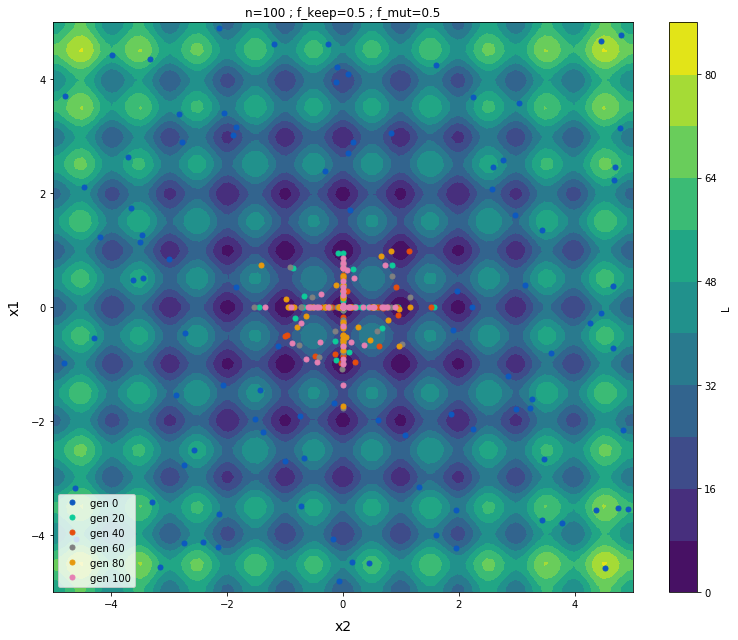

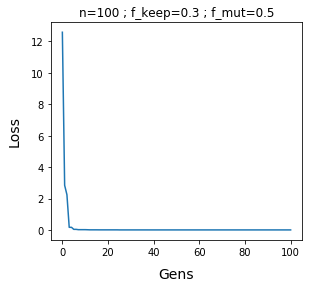

In [7]:
model = GA(rastrigin_pso,n=100,f_keep=0.3, f_mut=0.5)
model.initialize(-5,5)  

# We'll keep the best params discovered up to each generation
betas = [model.best_x] 
losses = [model.best_L] 

# Run the algorithm for 100 generations
for i in range(100):
    model.selection()
    model.crossover()
    model.mutation()

    betas += [model.best_x] 
    losses += [model.best_L] 

print("Best params (loss): {} ({})".format(betas[-1],losses[-1]))

# Plot trajectory (opt)
lines = [ model.beta[_] for _ in range(0,101,20) ]
labels = [ "gen {}".format(_) for _ in range(0,101,20)]
surf_plot(np.linspace(-5,5,100),np.linspace(-5,5,100),rastrigin,\
          dims=(11,9),lines=lines,c_opt=False,alpha=1.0,\
          linestyle="None",labels=labels,title="n=100 ; f_keep=0.5 ; f_mut=0.5")

# Plot the loss vs generations
plt.figure(figsize=(4.5,4))
plt.plot(range(101),losses)
plt.ylabel("Loss",fontsize=14,labelpad=10)
plt.xlabel("Gens",fontsize=14,labelpad=10)
plt.title("n=100 ; f_keep=0.3 ; f_mut=0.5")
plt.show()



The hyperparameters are relatively well-balanced in this case and the solution converges within ~5 generations. Note that the stripe/cross pattern in the later populations is due to the shape of the optimization surfaces (i.e., the best solutions that are kept in each iteration are the ones that minimize |x1| and |x2|).

Let's test a case where more mutations occur:

Best params (loss): [-0.00512998  0.00125776] (0.0010441283678019886)


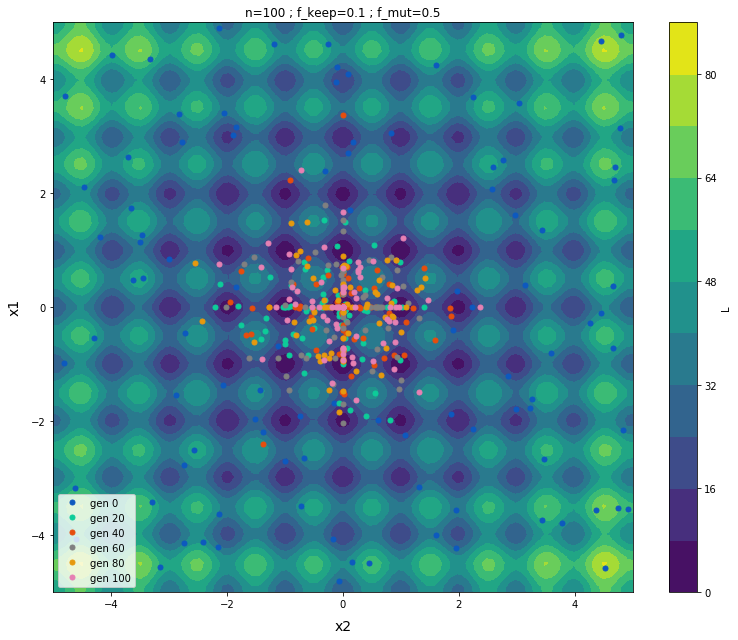

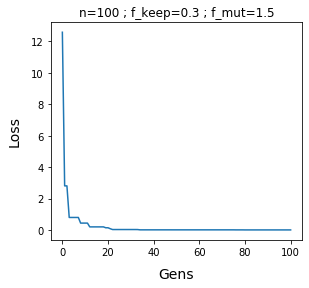

In [8]:
model = GA(rastrigin_pso,n=100,f_keep=0.3,f_mut=1.5)
model.initialize(-5,5)  

# We'll keep the best params discovered up to each generation
betas = [model.best_x] 
losses = [model.best_L] 

# Run the algorithm for 100 generations
for i in range(100):
    model.selection()
    model.crossover()
    model.mutation()

    betas += [model.best_x] 
    losses += [model.best_L] 

print("Best params (loss): {} ({})".format(betas[-1],losses[-1]))

# Plot trajectory (opt)
lines = [ model.beta[_] for _ in range(0,101,20) ]
labels = [ "gen {}".format(_) for _ in range(0,101,20)]
surf_plot(np.linspace(-5,5,100),np.linspace(-5,5,100),rastrigin,\
          dims=(11,9),lines=lines,c_opt=False,alpha=1.0,\
          linestyle="None",labels=labels,title="n=100 ; f_keep=0.1 ; f_mut=0.5")

# Plot the loss vs generations
plt.figure(figsize=(4.5,4))
plt.plot(range(101),losses)
plt.ylabel("Loss",fontsize=14,labelpad=10)
plt.xlabel("Gens",fontsize=14,labelpad=10)
plt.title("n=100 ; f_keep=0.3 ; f_mut=1.5")
plt.show()


The higher frequency of mutations leads to a marginal disruption of the cross pattern at later generations. Note, because of the way we have implemented mutations, the same gene can be mutated multiple times, so a value of `f_mut` greater than 1 is fine. Nevertheless, the solution takes longer to converge (~20 generations in this case).

Let's test a case where we only introduce a small number of new solutions and mutations in each generation:

Best params (loss): [2.70711185 0.08966955] (1.619009688668985)


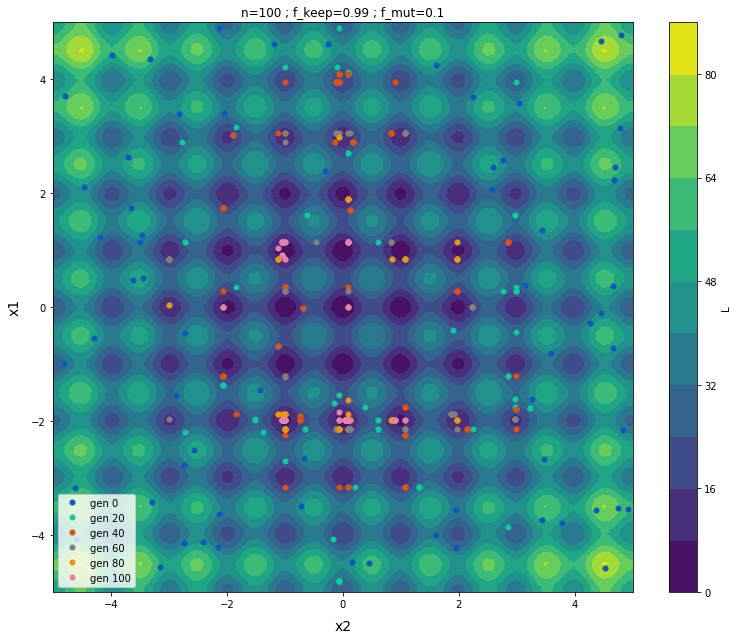

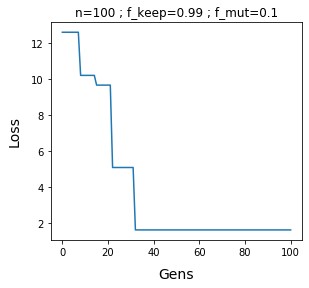

In [9]:
model = GA(rastrigin_pso,n=100,f_keep=0.95,f_mut=0.1)
model.initialize(-5,5)  

# We'll keep the best params discovered up to each generation
betas = [model.best_x] 
losses = [model.best_L] 

# Run the algorithm for 100 generations
for i in range(100):
    model.selection()
    model.crossover()
    model.mutation()

    betas += [model.best_x] 
    losses += [model.best_L] 

print("Best params (loss): {} ({})".format(betas[-1],losses[-1]))

# Plot trajectory (opt)
lines = [ model.beta[_] for _ in range(0,101,20) ]
labels = [ "gen {}".format(_) for _ in range(0,101,20)]
surf_plot(np.linspace(-5,5,100),np.linspace(-5,5,100),rastrigin,\
          dims=(11,9),lines=lines,c_opt=False,alpha=1.0,\
          linestyle="None",labels=labels,title="n=100 ; f_keep=0.99 ; f_mut=0.1")

# Plot the loss vs generations
plt.figure(figsize=(4.5,4))
plt.plot(range(101),losses)
plt.ylabel("Loss",fontsize=14,labelpad=10)
plt.xlabel("Gens",fontsize=14,labelpad=10)
plt.title("n=100 ; f_keep=0.99 ; f_mut=0.1")
plt.show()


The convergence is much slower in this case, and it doesn't actually find the best minimum. 

### Nelder-Mead (Simplex) Algorithm  ###
**This section is currently incomplete**

The last method we'll discuss is the Nelder-Mead algorithm, also known as the simplex method (although simplex methods are more general than NM). The Nelder-Mead method consists of evolving an n+1 set of candidate solutions (i.e., a "simplex"), where n is the number of parameters in our model. In a 2D problem, like minimizing the rastrigin function, the simplex would form a triangle. Based on the loss function evaluations on this triangle, you can image that we can estimate the derivative over the area of the triangle. However, NM doesn't ever use the derivative directly, instead it performs a small number of trials that perturb the vertices of the triangle, that effectively translate it and/or expand/contract it. These steps consist of sometimes reflecting one of the vertices, expanding one of the vertices away from the others, and contracting one of the vertices towards the center of the triangle (e.g., if the minimum seems to be inside of the area of the triangle). 

The beautiful insight of NM is that this small set of possible perturbations can be ordered to guarantee that the simplex crawls downhill to converge on a minimum. Revisting the case of the triangle for the 2D problem, a typical evolution of the triangle primarily consists of taking the worst point on the triangle and reflecting it across the others. This looks like a triangle rolling downhill. Once the simplex settles into a minimum, the triangle ends up contracting until it reaches a threshold criterion. 

Depending on how large the simplex is, it has the ability to walk out of sufficiently shallow minima, albeit not as robustly as the other heuristic methods we discussed. Nevertheless, the advantage of NM is that the simplex is only of size n+1 and so is very cheap to evolve and it doesn't require any direct gradient evaluations.  